# Studying the effect of gaussian shot noise on clustering analysis
*Written by Molly Kaplan*

We aim to preform a systematic study of noise as it effects geometric machine learning. In this part of the project, we focus on the effect of noise on clustering analysis for landmarks. In particular, we look below at data with 3 and 5 landmarks. 

Many of the datasets that scientists work with have significant sources of labeling error, either due to the humans that label those datasets or the ability of algorithms that we use to label large amounts of data from small amounts of labeled data. While landmarks are located at medically meaningful sites, there can easily be error introduced by humans or algorithms working to match medical definitions to specific points on medical images. Investigating the effect of noise can tell us whether the conclusions we draw from geometric machine learning algorithms can be trusted.

In this part of the project, we make synthetic data with two clusters. We use synthetic data instead of real data so that we can better control the algorithm accuracy, then compare to data with noise added. So, we start with the synthetic data, add Gaussian Shot noise, then run Agglomerative Hierarchical Clustering on the noisy and noiseless data. We end by visualizing our results.

# Defining the Gaussian Shot Noise Function
We add noise to each landmark coordinate with some probability. If we choose to add noise to a coordinate, the amount of noise is randomly sampled from a Gaussian distribution

In [2]:
import geomstats.backend as gs
import random


def shot_noise(set_of_landmarks, probability, sigma) :
    """Add gaussian shot noise to a data set of landmarks
    
    Parameters
    ----------
    set_of_landmarks : array-like
        Original data set
    probability : float, in the range 0 to 1
        Probability of getting introducing an error in each landmark direction
    sigma : float
        Sigma of the Gaussian distribution

    Returns
    -------
    noisy_data : array-like, of same dimensions as set_of_landmarks
        Data set with noise added to the original set of landmarks
    """
    
    rand_choice = gs.random.choice([0, 1], set_of_landmarks.shape, 
                                   p = [1 - probability, probability])
    rand_norm = gs.random.normal(0.0, sigma, size = set_of_landmarks.shape)
    noisy_data = set_of_landmarks + rand_norm*rand_choice
    
    return noisy_data

INFO: Using numpy backend


# Project Functions
We start by making synthetic landmark data that is split into two clusters (this is done in the function synthetic_clusters_2D). In cluster_ml(), we add noise, then perform agglomerative hierarchical clustering on the noisy and non-noisy data. We also define a function called simulation() to iterate over the clustering analysis for different data sets, then average over the accuracy (for both noisy and non-noisy data).

In [3]:
import math as m
import numpy as np
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
from geomstats.learning.agglomerative_hierarchical_clustering import AgglomerativeHierarchicalClustering


def synthetic_clusters_2D(points, sigma, n_data, k_landmarks):
    """Make a synthetic data set of landmarks in 2D, split into 2 clusters. 
    In making the data set, we make n_data new shapes, and change each point 
    in each shape by sampling from a Gaussian distribution. 
    
    After creating the data set, we rescale, translate, and rotate the shapes, 
    as they would be before projecting to preshape space.
    
    Parameters
    ----------
    points : array-like, with shape (2, k_landmarks, 2)
        Two starting shapes, to serve as the starting shape for each cluster
    sigma : float
        Sigma of the Gaussian distribution used to make the clusters.
    n_data : integer
        Number of shapes in each cluster
    k_landmarks : integer
        Number of landmarks in each shape

    Returns
    -------
    data : array-like, shape=[2*n_data, k_landmarks, 2]
        Data set of clustered data
    labels : array-like, shape=[2*n_data]
        Array labelling elements of the first cluster with '0' and the second 
        cluster with '1'
    """
    
    cluster1=[]
    for i in range(n_data):
        pt=points[0]+gs.random.normal(0,sigma,size=points[0].shape)
        
        theta=2*np.pi*random.random()
        rot = gs.array([[ m.cos(theta), -m.sin(theta) ],
                             [ m.sin(theta), m.cos(theta)]])
        
        pt*=gs.random.normal(1,1,size=(2))[0]
        pt=np.add(pt,gs.random.normal(0,2,size=(2)))
    
        for j in range(k_landmarks):
            pt[j]=np.matmul(rot,np.transpose(pt[j]))
        
        cluster1+=[pt]
        
        
    cluster2=[]
    for i in range(n_data):
        pt=points[1]+gs.random.normal(0,sigma,size=points[1].shape)
        
        theta=2*np.pi*random.random()
        rot = gs.array([[ m.cos(theta), -m.sin(theta) ],
                             [ m.sin(theta), m.cos(theta)]])
        
        pt*=gs.random.normal(1,1,size=(2))[0]
        pt=np.add(pt,gs.random.normal(0,2,size=(2)))
    
        for j in range(k_landmarks):
            pt[j]=np.matmul(rot,np.transpose(pt[j]))
        
        cluster2+=[pt]
    
    data=gs.array(cluster1+cluster2)
    labels=np.append(gs.zeros(n_data,dtype=int),np.ones(n_data,dtype=int))
    
    return data, labels


def cluster_ml(data, labels, probability, sigma, m_ambient, k_landmarks):
    """Runs Agglomerative Hierarchiacal Clustering on a provided data set.
    
    First projects the data to preshape space, then runs the machine learning
    algorithm. Also adds noise to the data, projects to preshape space, and
    runs the algorithm on that.
        
    Parameters
    ----------
    data : array-like, shape=[number of shapes, k_landmarks, m_ambient]
        Data set of landmarks
    labels : array like, shape=data.shape[0]
        Labels each shape with the cluster it belongs to
    n_data : integer
        Number of shapes in each cluster
    probability : float, in the range 0 to 1
        Probability of getting introducing an error in each landmark direction
    sigma : float
        Sigma of the Gaussian noise distribution
    m_ambient : integer
        Dimensions of landmark points
    k_landmarks : integer
        Number of landmarks in each shape
        
    Returns
    -------
    labels : array-like, shape=[2*n_data]
        Array labelling elements of the first cluster with '0' and the second 
        cluster with '1'
    predicted_labels : array-like, shape=[2*n_data]
        Array labelling the shapes according to the cluster assigned by the
        clustering algorithm
    accuracy : float, in the range 0.5 to 1
        Accuracy of the algorithm, computed by comparing predicted_labels to
        labels
    dist_pairwise : array-like, shape=[2*n_data, 2*n_data]
        Pairwise distance matrix between all the points.
    noisy_predicted_labels : array-like, shape=[2*n_data]
        Array labelling the shapes according to the cluster assigned by the
        clustering algorithm for the noisy data
    noisy_accuracy : float, in the range 0.5 to 1
        Accuracy of the algorithm on the noisy data, computed by comparing 
        noisy_predicted_labels to labels
    noisy_dist_pairwise : array-like, shape=[2*n_data, 2*n_data]
        Pairwise distance matrix between all the points.
    """
    
    preshape = PreShapeSpace(m_ambient = m_ambient, k_landmarks = k_landmarks)
    metric = KendallShapeMetric(k_landmarks=k_landmarks, m_ambient=m_ambient)
    
    data_new = preshape.projection(data)
    
    base_point = data_new[0]
    data_shape = preshape.align(point=data_new, base_point=base_point)
    
    dist_pairwise = metric.dist_pairwise(data_shape)
    
    clustering = AgglomerativeHierarchicalClustering(distance="precomputed", n_clusters=2)
    clustering.fit(dist_pairwise)
    predicted_labels = clustering.labels_
    
    if gs.sum(labels == predicted_labels) / len(labels) > 0.5:
        accuracy = gs.sum(labels == predicted_labels) / len(labels)
    else:
        accuracy = 1-gs.sum(labels == predicted_labels) / len(labels)
        
        
    """Adding noise and applying agglomerative hierarchial clustering"""
    noisy_rand_data = shot_noise(data, probability, sigma)
    noisy_data = preshape.projection(noisy_rand_data)
    
    noisy_base_point = noisy_data[0]
    noisy_data_shape = preshape.align(point=noisy_data, base_point=noisy_base_point)
    
    noisy_dist_pairwise = metric.dist_pairwise(noisy_data_shape)
    
    noisy_clustering = AgglomerativeHierarchicalClustering(distance="precomputed", n_clusters=2)
    noisy_clustering.fit(noisy_dist_pairwise)
    noisy_predicted_labels = noisy_clustering.labels_
    
    if gs.sum(labels == noisy_predicted_labels) / len(labels) > 0.5:
        noisy_accuracy = gs.sum(labels == noisy_predicted_labels) / len(labels)
    else:
        noisy_accuracy = 1.0-gs.sum(labels == noisy_predicted_labels) / len(labels)
        
    
    return (labels, predicted_labels, accuracy, dist_pairwise, 
            noisy_predicted_labels, noisy_accuracy, noisy_dist_pairwise)

# Visualizing clustering
Now, we plot the pairwise distance for different values of probability and sigma. We can see less clustering as we add more noise. This visualization method works well for data sets with many landmarks or many dimensions in the ambient space; we use it even though we have the rather simple case of 2D with 3 landmarks, so that our work can be easily generalized in the next code block.

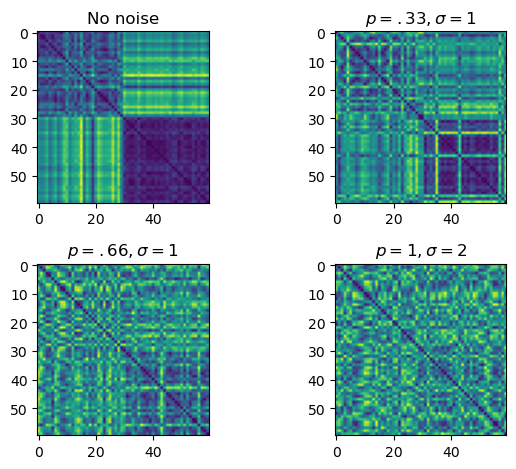

In [5]:
import matplotlib.pyplot as plt

def plot_dist_pairwise_k3(n_data):
    """Plots the pairwise distance matrix for sample data with 
        (1) no noise, 
        (2) noise with p=.33, sigma=1,
        (3) noise with p=.66, sigma=1.5, and
        (4) noise with p=1, sigma=2l
    
    Parameters
    ----------
    n_data : integer
        Number of shapes in each cluster
        
    Returns
    -------
    Four plots
    """
    m_ambient = 2
    k_landmarks = 3
    
    points=gs.array([[[-.5,0],[-.5,1],[.5,0]],[[-3,0],[0,.25],[3,0]]])
    data, labels = synthetic_clusters_2D(points, .35, n_data, k_landmarks)
    
    fig, ax = plt.subplots(2,2)
        
    ax[0,0].imshow(cluster_ml(data, labels, 0,0,m_ambient,k_landmarks)[3])
    ax[0,1].imshow(cluster_ml(data, labels, .33,1,m_ambient,k_landmarks)[6])
    ax[1,0].imshow(cluster_ml(data, labels, .66,1.5,m_ambient,k_landmarks)[6])
    ax[1,1].imshow(cluster_ml(data, labels, 1,2,m_ambient,k_landmarks)[6])
    
    ax[0,0].set_title('No noise')
    ax[0,1].set_title(r'$p=.33,\sigma=1$')
    ax[1,0].set_title(r'$p=.66,\sigma=1$')
    ax[1,1].set_title(r'$p=1,\sigma=2$')
        
    plt.tight_layout()
    plt.show()
    
    
plot_dist_pairwise_k3(30)

We now generalize to the case with 5 landmarks.

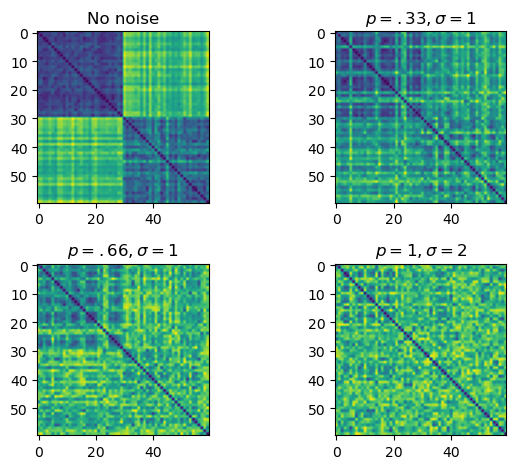

In [10]:
import matplotlib.pyplot as plt

def plot_dist_pairwise_k5(n_data):
    """Plots the pairwise distance matrix for sample data with 
        (1) no noise, 
        (2) noise with p=.33, sigma=1,
        (3) noise with p=.66, sigma=1.5, and
        (4) noise with p=1, sigma=2l
    
    Parameters
    ----------
    n_data : integer
        Number of shapes in each cluster
        
    Returns
    -------
    Four plots
    """
    m_ambient = 2
    k_landmarks = 5
    
    points=gs.array([[[-1,0],[-2,1],[0,2],[2,1],[1,0]],[[-.5,0],[-.5,1],[0,2],[.5,1],[.5,0]]])
    data, labels = synthetic_clusters_2D(points, .2, n_data, k_landmarks)
    
    fig, ax = plt.subplots(2,2)
        
    ax[0,0].imshow(cluster_ml(data, labels, 0,0,m_ambient,k_landmarks)[3])
    ax[0,1].imshow(cluster_ml(data, labels, .33,1,m_ambient,k_landmarks)[6])
    ax[1,0].imshow(cluster_ml(data, labels, .66,1.5,m_ambient,k_landmarks)[6])
    ax[1,1].imshow(cluster_ml(data, labels, 1,2,m_ambient,k_landmarks)[6])
    
    ax[0,0].set_title('No noise')
    ax[0,1].set_title(r'$p=.33,\sigma=1$')
    ax[1,0].set_title(r'$p=.66,\sigma=1$')
    ax[1,1].set_title(r'$p=1,\sigma=2$')
        
    plt.tight_layout()
    plt.show()
    
    
plot_dist_pairwise_k5(30)

# Plotting the accuracy
Finally, we plot these noiseless and noisy average accuracies against different values of sigma for the gaussian noise distribution. We show four plots, each with a different value of shot noise probability. We do this for first for the case with 3 landmarks:

(20, 60, 3, 2)


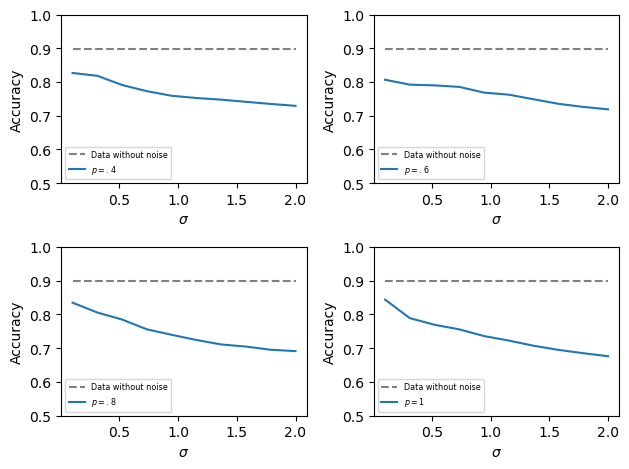

In [27]:
import matplotlib.pyplot as plt

def plot_accuracy_k3(n_data,n_times,n_points):
    """Plots the average accuracy of cluster_ml() when run a specified number
    of times (n_times), for data with and without noise. The accuracy is plotted
    against sigma for n_points different values of sigma between .1 and 2. 
    
    The output is four different plots, each plot with a different probability 
    for shot noise on the data set. The probabilities shown are p=.4, .6, .8, and 1.
        
    Parameters
    ----------
    n_data : integer
        Number of shapes in each cluster
    n_times : integer
        Number of iterations of cluster_ml()
    n_points : integer
        Number of sigma points where we evaluate 
        
    Returns
    -------
    Four plots
    """
    m_ambient = 2
    k_landmarks = 3
    
    data_lst = []
    labels_lst = []
    points=gs.array([[[-.5,0],[-.5,1],[.5,0]],[[-3,0],[0,.25],[3,0]]])
    for i in range(n_times):
        data, labels = synthetic_clusters_2D(points, .35, n_data, k_landmarks)
        data_lst += [data]
        labels_lst += [labels]
    data_lst=gs.array(data_lst)
    labels_lst=gs.array(labels_lst) 
    
    fig = plt.figure(); 
    axtl = fig.add_subplot(221) 
    axtr = fig.add_subplot(222) 
    axbl = fig.add_subplot(223) 
    axbr = fig.add_subplot(224)
    ax= [axtl, axtr, axbl, axbr]
    
    for axi in ax:
        axi.set_ylim((.5, 1))
    
    label_to_str = {0: "Data without noise", 1: r'$p=.4$', 
                    2:r'$p=.6$', 3:r'$p=.8$', 4:r'$p=1$'}
    
    for i in range(4):
        noisy_accuracy = []
        accuracy = []
        sigma=np.linspace(.1,2,num=n_points)
        acc_lst = []
        noisy_acc_lst=[]
        
        for k in sigma:
            for j in range(n_times):
                outputs = cluster_ml(data_lst[j], labels_lst[j], .2*i+.4, k, m_ambient, k_landmarks)
                accuracy_out = outputs[2]
                noisy_accuracy_out = outputs[5]
                acc_lst+= [accuracy_out]
                noisy_acc_lst+=[noisy_accuracy_out]
        
            avg_acc = sum(acc_lst)/len(acc_lst)
            avg_noisy_acc = sum(noisy_acc_lst)/len(noisy_acc_lst)
            
            accuracy = np.append(accuracy,avg_acc)
            noisy_accuracy = np.append(noisy_accuracy,avg_noisy_acc)
        
        ax[i].plot(sigma,accuracy, linestyle='--', color='gray',label=label_to_str[0])
        ax[i].plot(sigma,noisy_accuracy,label=label_to_str[i+1])
        
        ax[i].set_xlabel(r'$\sigma$')
        ax[i].set_ylabel('Accuracy')
        
        ax[i].legend(fontsize='xx-small')
        
    plt.tight_layout()
    plt.show()
    
plot_accuracy_k3(30,20,10)

And now for the case with 5 landmarks:

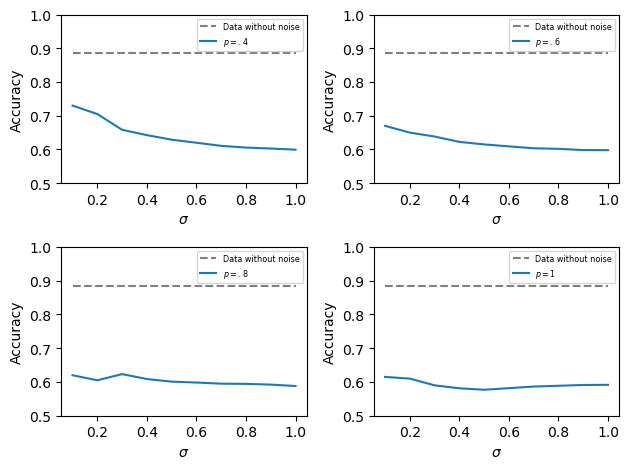

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy_k5(n_data,n_times,n_points,sig_min=.1,sig_max=1):
    """Plots the average accuracy of cluster_ml() when run a specified number
    of times (n_times), for data with and without noise. The accuracy is plotted
    against sigma for n_points different values of sigma between .1 and 2. 
    
    The output is four different plots, each plot with a different probability 
    for shot noise on the data set. The probabilities shown are p=.4, .6, .8, and 1.
        
    Parameters
    ----------
    n_data : integer
        Number of shapes in each cluster
    n_times : integer
        Number of iterations of cluster_ml()
    n_points : integer
        Number of sigma points where we evaluate 
        
    Returns
    -------
    Four plots
    """
    m_ambient = 2
    k_landmarks = 5
    
    data_lst = []
    labels_lst = []
    points=gs.array([[[-1,0],[-2,1],[0,2],[2,1],[1,0]],[[-.5,0],[-.5,1],[0,2],[.5,1],[.5,0]]])
    for i in range(n_times):
        data, labels = synthetic_clusters_2D(points, .35, n_data, k_landmarks)
        data_lst += [data]
        labels_lst += [labels]
    data_lst=gs.array(data_lst)
    labels_lst=gs.array(labels_lst) 
    
    fig = plt.figure(); 
    axtl = fig.add_subplot(221) 
    axtr = fig.add_subplot(222) 
    axbl = fig.add_subplot(223) 
    axbr = fig.add_subplot(224)
    ax= [axtl, axtr, axbl, axbr]
    
    for axi in ax:
        axi.set_ylim((.5, 1))
    
    label_to_str = {0: "Data without noise", 1: r'$p=.4$', 
                    2:r'$p=.6$', 3:r'$p=.8$', 4:r'$p=1$'}
    
    for i in range(4):
        noisy_accuracy = []
        accuracy = []
        sigma=np.linspace(sig_min,sig_max,num=n_points)
        acc_lst = []
        noisy_acc_lst=[]
        
        for k in sigma:
            for j in range(n_times):
                outputs = cluster_ml(data_lst[j], labels_lst[j], .2*i+.4, k, m_ambient, k_landmarks)
                accuracy_out = outputs[2]
                noisy_accuracy_out = outputs[5]
                acc_lst+= [accuracy_out]
                noisy_acc_lst+=[noisy_accuracy_out]
        
            avg_acc = sum(acc_lst)/len(acc_lst)
            avg_noisy_acc = sum(noisy_acc_lst)/len(noisy_acc_lst)
            
            accuracy = np.append(accuracy,avg_acc)
            noisy_accuracy = np.append(noisy_accuracy,avg_noisy_acc)
        
        ax[i].plot(sigma,accuracy, linestyle='--', color='gray',label=label_to_str[0])
        ax[i].plot(sigma,noisy_accuracy,label=label_to_str[i+1])
        
        ax[i].set_xlabel(r'$\sigma$')
        ax[i].set_ylabel('Accuracy')
        
        ax[i].legend(fontsize='xx-small')
        
    plt.tight_layout()
    plt.show()
    
plot_accuracy_k5(10,10,10)

Let's zoom in a bit:

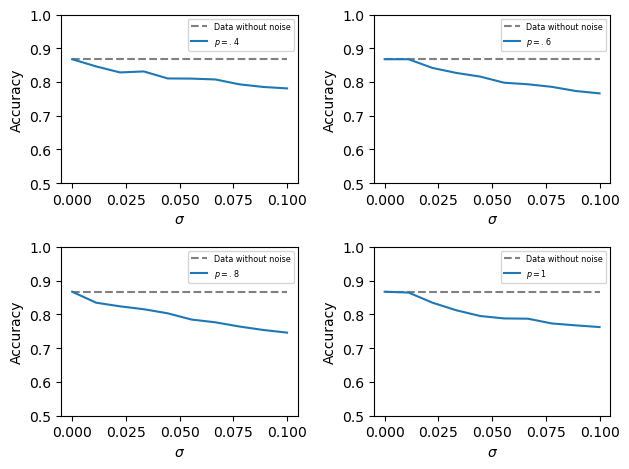

In [18]:
plot_accuracy_k5(10,20,10,0,.1)